## (Towards) valid partition testing via count splitting

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.models import SBMEstimator
from graspologic.plot import heatmap
from graspologic.simulations import er_np
from pkg.plot import set_theme
from scipy.stats import chi2_contingency, ks_1samp, uniform
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm

set_theme()
rng = np.random.default_rng(8888)
np.random.seed(99999)


def compute_params(graph):
    n_edges = np.count_nonzero(graph)
    n_possible = graph.size
    return n_edges, n_possible - n_edges


def get_subgraphs(graph, labels):
    uni_labels = np.unique(labels)
    subgraphs = []
    for i in uni_labels:
        for j in uni_labels:
            subgraph = graph[labels == i][:, labels == j]
            subgraphs.append(subgraph)
    return subgraphs


def estimate_partition_gmm(A, n_components=2, n_init=1):
    ase = AdjacencySpectralEmbed(n_components=n_components, concat=True)
    X = ase.fit_transform(A)
    gmm = GaussianMixture(n_components=n_components, n_init=n_init)
    gmm.fit(X)
    pred_labels = gmm.predict(X)
    return pred_labels


def estimate_partition_spectral_modularity(A):
    A_sym = (A + A.T) / 2
    degrees = A_sym.sum(axis=0)
    m = degrees.sum()  # TODO half here?
    B = A_sym - 1 / m * degrees[:, None] * degrees[None, :]
    _, eigenvectors = np.linalg.eigh(B)
    # eigh returns eigenvectors in ascending order by eigenvalue
    first_eigenvector = np.squeeze(np.asarray(eigenvectors[:, -1]))
    eig_partition = first_eigenvector.copy()
    eig_partition[eig_partition > 0] = 1
    eig_partition[eig_partition <= 0] = 0
    eig_partition = eig_partition.astype(int)
    return eig_partition


def old_count_split(A, train_size=0.5, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    subsample_mask = rng.binomial(1, train_size, size=(n, n)).astype(bool)

    A_train = np.zeros_like(A)
    A_test = np.zeros_like(A)
    A_train[subsample_mask] = A[subsample_mask]
    A_test[~subsample_mask] = A[~subsample_mask]

    return A_train, A_test


def count_split(A, train_size=0.5, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    A_train = rng.binomial(A.astype(int), train_size)
    A_test = A - A_train

    return A_train, A_test


def estimate_block_probabilities(A, labels):
    sbm = SBMEstimator(directed=True, loops=True)
    sbm.fit(A, labels)
    B = sbm.block_p_
    return B

In [2]:

p = 0.3
n = 100

n_sims = 1000
rows = []
B_tests = []
B_trains = []
for i in tqdm(range(n_sims)):
    A = er_np(n, p, directed=True, loops=True).astype(int)

    A_train, A_test = count_split(A)

    # pred_labels = estimate_partition_gmm(A_train)
    pred_labels = estimate_partition_spectral_modularity(A_train)

    B_trains.append(estimate_block_probabilities(A_train, pred_labels))
    B_tests.append(estimate_block_probabilities(A_test, pred_labels))

    for graph, data_name in zip([A_train, A_test], ["train", "test"]):

        subgraphs = get_subgraphs(graph, pred_labels)

        # this just makes the 4 x 2 table (subgraph x edge/no edge) for the chi2 test
        table = np.array([compute_params(subgraph) for subgraph in subgraphs])

        stat, pvalue, _, expected = chi2_contingency(table)

        result = {
            "pvalue": pvalue,
            "data": data_name,
        }
        rows.append(result)

results = pd.DataFrame(rows)

B_test_mean = np.mean(B_tests, axis=0)
B_train_mean = np.mean(B_trains, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

## What does the average $\hat{B}$ matrix look like?

Text(0.5, 1.0, '$\\hat{B}$ from test network')

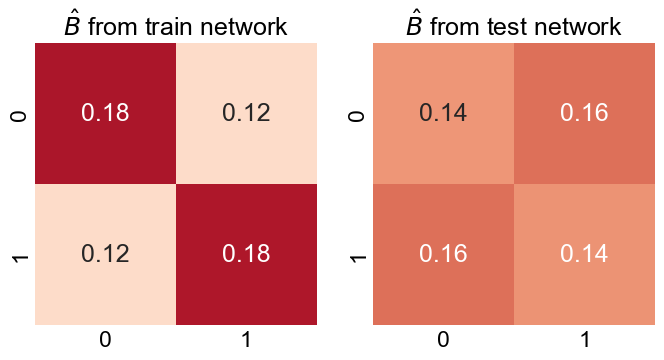

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

heatmap_kws = dict(square=True, cbar=False, cmap="RdBu_r", vmin=0, vmax=0.2, annot=True)

ax = axs[0]
sns.heatmap(B_train_mean, ax=ax, **heatmap_kws)
ax.set_title(r"$\hat{B}$ from train network")

ax = axs[1]
sns.heatmap(B_test_mean, ax=ax, **heatmap_kws)
ax.set_title(r"$\hat{B}$ from test network")

## Are the p-values sub-uniform?

Text(0.5, 1.0, 'Test network')

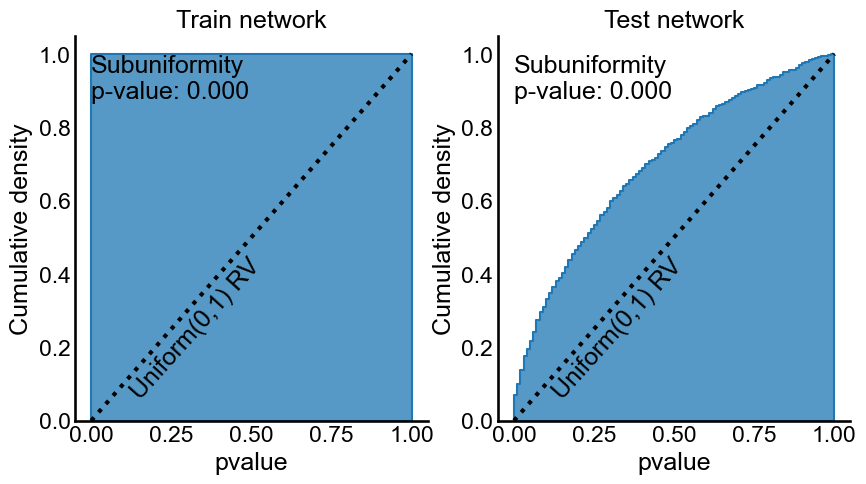

In [4]:


def subuniformity_plot(x, ax=None, write_pvalue=True, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.histplot(x, ax=ax, stat="density", cumulative=True, **kwargs)
    stat, pvalue = ks_1samp(x, uniform(0, 1).cdf, alternative="greater")
    if write_pvalue:
        ax.text(0, 1, f"Subuniformity\np-value: {pvalue:.3f}", va="top")
    ax.plot([0, 1], [0, 1], linewidth=3, linestyle=":", color="black")
    ax.set_ylabel("Cumulative density")
    ax.text(
        0.11,
        0.09,
        "Uniform(0,1) RV",
        rotation=48,
        va="top",
        ha="left",
        rotation_mode="anchor",
    )
    return ax, stat, pvalue


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

subuniformity_plot(
    x=results.query("data == 'train'")["pvalue"],
    ax=axs[0],
    binwidth=0.01,
    binrange=(0, 1),
    element="step",
)
axs[0].set_title("Train network")

subuniformity_plot(
    x=results.query("data == 'test'")["pvalue"],
    ax=axs[1],
    binwidth=0.01,
    binrange=(0, 1),
    element="step",
)
axs[1].set_title("Test network")

## Just trying to draw what is going on, not essential to simulation

<AxesSubplot:title={'center':'A test partitioned'}>

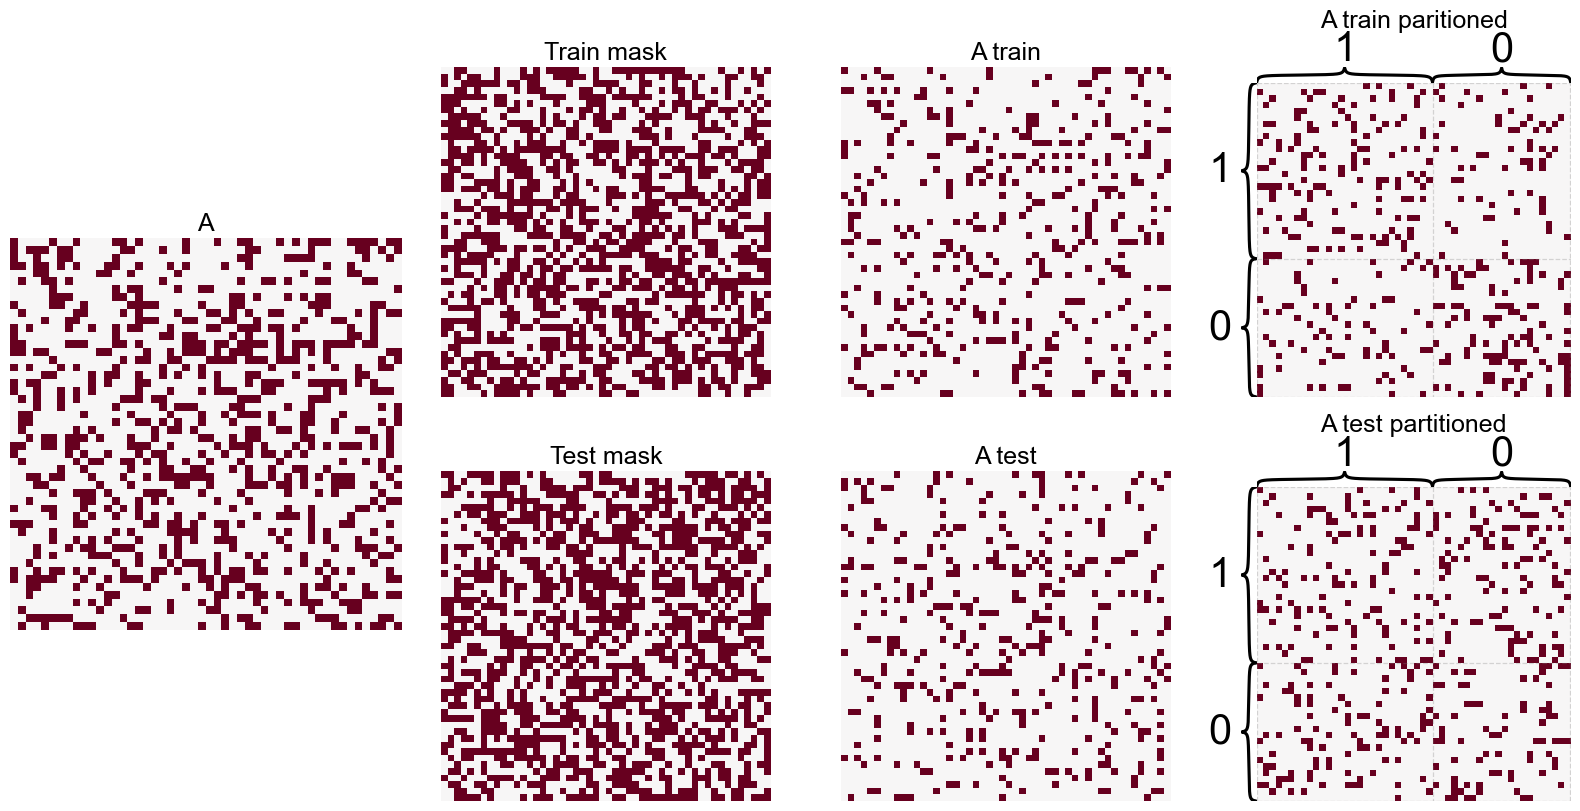

In [5]:
from giskard.plot import merge_axes


p = 0.3
n = 50
A = er_np(n, p, directed=True, loops=True)
subsample_mask = rng.binomial(1, 0.5, size=(n, n)).astype(bool)
A_train = np.zeros_like(A)
A_test = np.zeros_like(A)
A_train[subsample_mask] = A[subsample_mask]
A_test[~subsample_mask] = A[~subsample_mask]
n_rows = 2
n_cols = 4
size = 4

heatmap_kws = dict(cbar=False, title_pad=40)
fig, axs = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * size, n_rows * size), constrained_layout=True
)
ax = merge_axes(fig, axs, cols=0)
heatmap(A, ax=ax, **heatmap_kws)
ax.set_title("A")
ax = axs[0, 1]
heatmap(subsample_mask, ax=ax, **heatmap_kws)
ax.set_title("Train mask")
ax = axs[1, 1]
heatmap(~subsample_mask, ax=ax, **heatmap_kws)
ax.set_title("Test mask")
ax = axs[0, 2]
heatmap(A_test, ax=ax, **heatmap_kws)
ax.set_title("A train")
ax = axs[1, 2]
heatmap(A_train, ax=ax, **heatmap_kws)
ax.set_title("A test")


# pred_labels = estimate_partition_gmm(A_train)
pred_labels = estimate_partition_spectral_modularity(A_train)

ax = axs[0, 3]

heatmap(
    A_train,
    inner_hier_labels=pred_labels,
    ax=ax,
    title="A train paritioned",
    **heatmap_kws,
)

ax = axs[1, 3]
heatmap(
    A_test,
    inner_hier_labels=pred_labels,
    ax=ax,
    title="A test partitioned",
    **heatmap_kws,
)